In [2]:
pip install tqdm

  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import pandas as pd
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train_data = pd.read_csv('C:/Users/davyd/Downloads/PYTORCH/Mnist/mnist_test.csv')
test_data = pd.read_csv('C:/Users/davyd/Downloads/PYTORCH/Mnist/mnist_test.csv')

In [ ]:
def CLASS_COUNT(paths,path, class_n):
    class_counts=pd.DataFrame(columns=["class_name"], index= range(len(paths)))
                
    for i in range (len(paths)):
        try:
            f = open(path+"/"+paths[i], 'r')
            class_name=f.read()
            class_name=int(class_name[0])
            if class_name in range(0,6):
                class_counts.loc[i,"class_name"]=int(class_name)
            else:
                print(class_name , i)
        except:
            print(i)

    class_counts.dropna(inplace=True)
    df=class_counts["class_name"].value_counts().sort_values()

    data={
        "class_index": [i for i in range(0,6)],
        "count":[df.iloc[i] for i in range(6)]
    }

    df=pd.DataFrame(data)

    # Создаем данные для диаграммы
    x = data["class_index"]
    y = data["count"]

    # Создаем столбчатую диаграмму
    fig = go.Figure(data=[go.Bar(x=x, y=y)])

    fig.update_layout(
        title= f'COUNTS {class_n} CLASS',  # Заголовок графика  # Подпись оси x
        yaxis_title='Count',  # Подпись оси y
        width=800,  # Ширина в пикселях
        height=600,  # Высота в пикселях
    )

    # Отображаем диаграмму
    fig.show()

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.pics = data.drop(columns = ['label']).values
        self.labels = data['label'].values
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, i):
        return torch.tensor(self.pics[i]) / 255, torch.tensor(self.labels[i])

In [6]:
train_dataset = Dataset(train_data)
test_dataset = Dataset(test_data)

In [9]:
train_dataset[0][0].shape[0]

784

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [11]:
class mlp(torch.nn.Module):
    def __init__(self, hidden_dim,hidden_dim_1):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=train_dataset[0][0].shape[0], out_features=hidden_dim, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dim_1, out_features=hidden_dim_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dim_1, out_features=10, bias=True),
        )
        
    def forward(self, x):
        x = self.mlp(x)
        return x

In [12]:
model = mlp(hidden_dim = 512,hidden_dim_1=256)

In [ ]:
def Vubros(tip, path_label,path_images)  
    print(tip)
    paths_label=os.listdir(path_label)
    paths_images=os.listdir(path_images)
    count_oshibka=0
    for i in range(len(paths_label)):
        f = open(path_label+"/"+paths_label[i], 'r')
        class_name=f.read()
        if  str(class_name.split(" ")[0]) not in ['0','1','2','3','4','5']:
            count_oshibka+=1
            f.close()
            os.remove(path_label+"/"+paths_label[i])
            os.remove(path_images+"/"+paths_images[i])

            print(f"Ошибка в label {i}")
        else:
            try:
                class_name.split(" ")[0]+class_name.split(" ")[1]+class_name.split(" ")[2]+class_name.split(" ")[3]
            except:
                count_oshibka+=1
                f.close()
                os.remove(path_label+"/"+paths_label[i])
                os.remove(path_images+"/"+paths_images[i])
                print(f"Ошибка в label {i}")

In [13]:
epochs = 10
device = 'cpu' # <- for mac
#for nvidia -> device = 'cuda' 

optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
def train_epoch(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    device
):
    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    model.train()
    # Training process
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        preds = model(x).softmax(dim = 1)
        
        loss = loss_fn(preds, y)
        
        train_losses.append(loss / len(train_dataloader))
        train_accuracy.append(((preds.argmax(dim = 1) == y).sum() / x.shape[0]) / len(train_dataloader))
    
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x).softmax(dim = 1)

            loss = loss_fn(preds, y)
            
            test_losses.append(loss / len(test_dataloader))
            test_accuracy.append(((preds.argmax(dim = 1) == y).sum() / x.shape[0])/ len(test_dataloader))

    
    print(f'''
        Train Loss: {sum(train_losses)}
        Train accuracy: {sum(train_accuracy)}
        Test Loss: {sum(test_losses)}
        Test accuracy: {sum(test_accuracy)}
    ''')
    
    return sum(train_losses), sum(test_losses), sum(train_accuracy), sum(test_accuracy)
        
        
        

In [15]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
for epoch_i in tqdm(range(epochs)):
    epoch_train_losses, epoch_test_losses, epoch_train_accuracy, epoch_test_accuracy = train_epoch(
        model,
        train_dataloader,
        test_dataloader,
        optim,
        loss_fn,
        device
    )
    train_losses.append(epoch_train_losses)
    test_losses.append(epoch_test_losses)
    train_accuracy.append(epoch_train_accuracy)
    test_accuracy.append(epoch_test_accuracy)

 10%|████████████████████                                                                                                                                                                                    | 1/10 [00:01<00:14,  1.61s/it]


        Train Loss: 1.8289639949798584
        Train accuracy: 0.6614913940429688
        Test Loss: 1.6639559268951416
        Test accuracy: 0.8038963675498962
    


 20%|████████████████████████████████████████                                                                                                                                                                | 2/10 [00:04<00:19,  2.46s/it]


        Train Loss: 1.6332074403762817
        Train accuracy: 0.8310917615890503
        Test Loss: 1.6098511219024658
        Test accuracy: 0.8542325496673584
    


 30%|████████████████████████████████████████████████████████████                                                                                                                                            | 3/10 [00:08<00:21,  3.04s/it]


        Train Loss: 1.6156057119369507
        Train accuracy: 0.8473098874092102
        Test Loss: 1.6120134592056274
        Test accuracy: 0.8504744172096252
    


 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 4/10 [00:11<00:19,  3.25s/it]


        Train Loss: 1.60299551486969
        Train accuracy: 0.8599682450294495
        Test Loss: 1.5890154838562012
        Test accuracy: 0.8737144470214844
    


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 5/10 [00:15<00:16,  3.35s/it]


        Train Loss: 1.5919773578643799
        Train accuracy: 0.8706488013267517
        Test Loss: 1.5837053060531616
        Test accuracy: 0.878263533115387
    


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 6/10 [00:18<00:13,  3.36s/it]


        Train Loss: 1.537383794784546
        Train accuracy: 0.9286985993385315
        Test Loss: 1.5231671333312988
        Test accuracy: 0.9411590099334717
    


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7/10 [00:21<00:09,  3.26s/it]


        Train Loss: 1.51621675491333
        Train accuracy: 0.9469937086105347
        Test Loss: 1.5033055543899536
        Test accuracy: 0.9605420231819153
    


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8/10 [00:25<00:06,  3.32s/it]


        Train Loss: 1.5049901008605957
        Train accuracy: 0.958366334438324
        Test Loss: 1.4982091188430786
        Test accuracy: 0.9646957516670227
    


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9/10 [00:29<00:03,  3.45s/it]


        Train Loss: 1.5018047094345093
        Train accuracy: 0.9608385562896729
        Test Loss: 1.490767002105713
        Test accuracy: 0.9714203476905823
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.30s/it]


        Train Loss: 1.4950892925262451
        Train accuracy: 0.9674644470214844
        Test Loss: 1.4896740913391113
        Test accuracy: 0.972211480140686
    


In [16]:
accuracy_train=[]
for i in range(len(train_accuracy)):
    accuracy_train.append(train_accuracy[i].tolist())

In [19]:
accuracy_test=[]
for i in range(len(test_accuracy)):
    accuracy_test.append(test_accuracy[i].tolist())

In [21]:
losses_train=[]
for i in range(len(train_losses)):
    losses_train.append(train_losses[i].tolist())

In [22]:
losses_test=[]
for i in range(len(test_losses)):
    losses_test.append(test_losses[i].tolist())

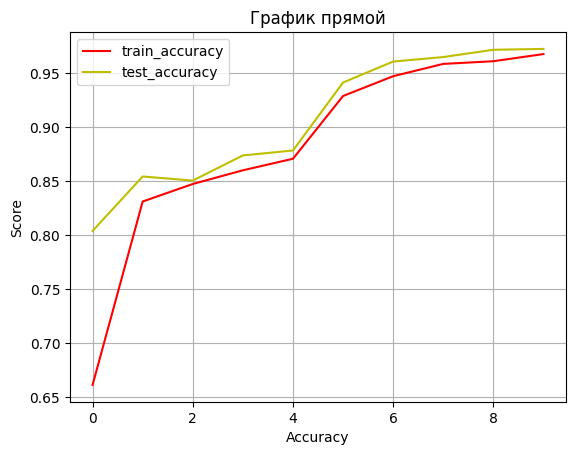

In [23]:
plt.plot(accuracy_train, '-r', label='train_accuracy')
plt.plot(accuracy_test, '-y', label='test_accuracy')# Построение прямой
plt.title('График прямой')  # Заголовок
plt.xlabel('Accuracy')  # Подпись оси x
plt.ylabel('Score')  # Подпись оси y
plt.legend(loc='upper left')  # Отображение легенды
plt.grid()  # Отображение сетки
plt.show()  # Отображение графика

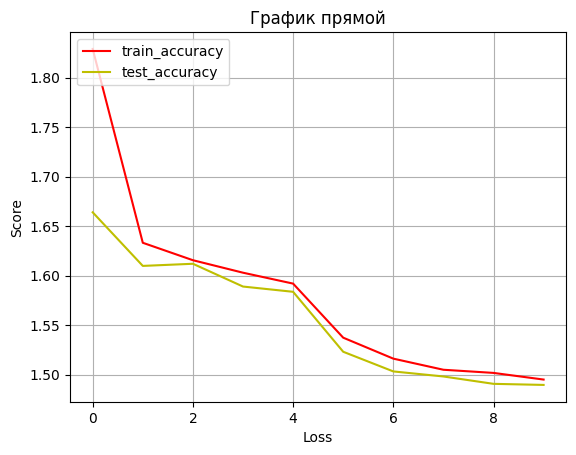

In [24]:
plt.plot(losses_train, '-r', label='train_accuracy')
plt.plot(losses_test, '-y', label='test_accuracy')# Построение прямой
plt.title('График прямой')  # Заголовок
plt.xlabel('Loss')  # Подпись оси x
plt.ylabel('Score')  # Подпись оси y
plt.legend(loc='upper left')  # Отображение легенды
plt.grid()  # Отображение сетки
plt.show()  # Отображение графика